In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import marimo
import warnings
warnings.filterwarnings('ignore')

In [55]:
# processed dataset load

df = pd.read_csv('flight_data_processed.csv')

In [56]:
# define features and target

features = [
    'dep_time_min',      # scheduled departure time
    'distance',          # flight distance  
    'origin',            # origin airport
    'day_of_month',      # day of month
    'day_of_week',       # day of week
    'month',             # month of flight
    'dep_hour',          # hour of departure
    'origin_avg_delay',  # historical airport delay stats
    'monthly_avg_delay', # historical monthly delay patterns
    'dow_avg_delay',     # historical day-of-week delay patterns
    'hourly_avg_delay'   # historical hourly delay patterns
]
target = 'actual_arrival_min'

X = df[features]
y = df[target]

In [57]:
# handle NaN in target

nan_in_y = y.isna().sum()
if nan_in_y > 0:
    valid_mask = ~y.isna()
    X = X[valid_mask]
    y = y[valid_mask]

In [58]:
# label encoding

X_encoded = X.copy()
X_encoded['origin'] = LabelEncoder().fit_transform(X_encoded['origin'])

In [59]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=777, shuffle=True
)

In [60]:
# LightGBM model

print('Training LightGBM...')
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=777, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 818259, number of used features: 11
[LightGBM] [Info] Start training from score 952.289766


In [61]:
# calculate metrics

lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print(f'LightGBM - MAE: {lgb_mae:.2f} min, RMSE: {lgb_rmse:.2f} min, R2: {lgb_r2:.4f}')

LightGBM - MAE: 20.90 min, RMSE: 50.71 min, R2: 0.9732


In [62]:
# Feature Importance

feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance['importance_pct'] = (feature_importance['importance'] / 
                                        feature_importance['importance'].sum() * 100)

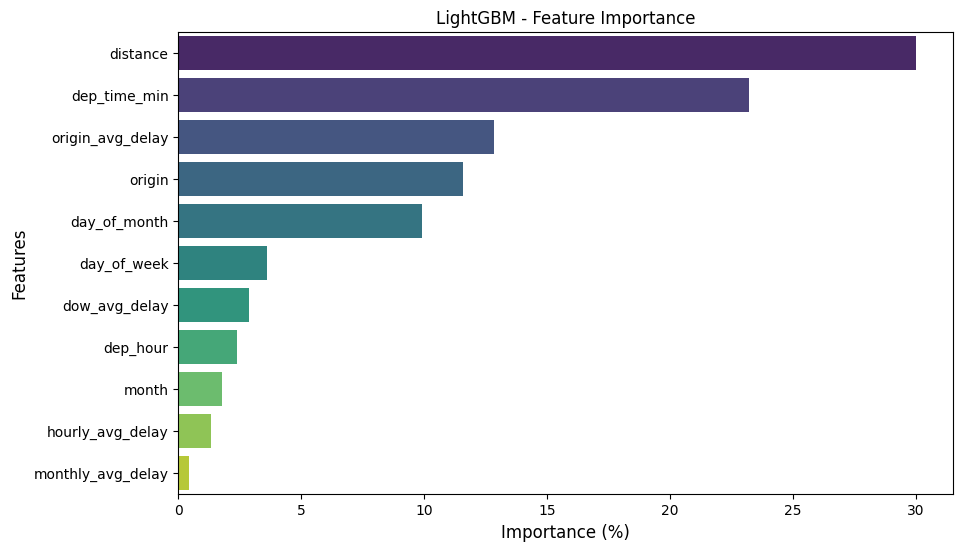

In [63]:
# visualization 1: Feature Importance

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance_pct', y='feature', palette='viridis')
plt.title('LightGBM - Feature Importance', fontsize=12)
plt.xlabel('Importance (%)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)

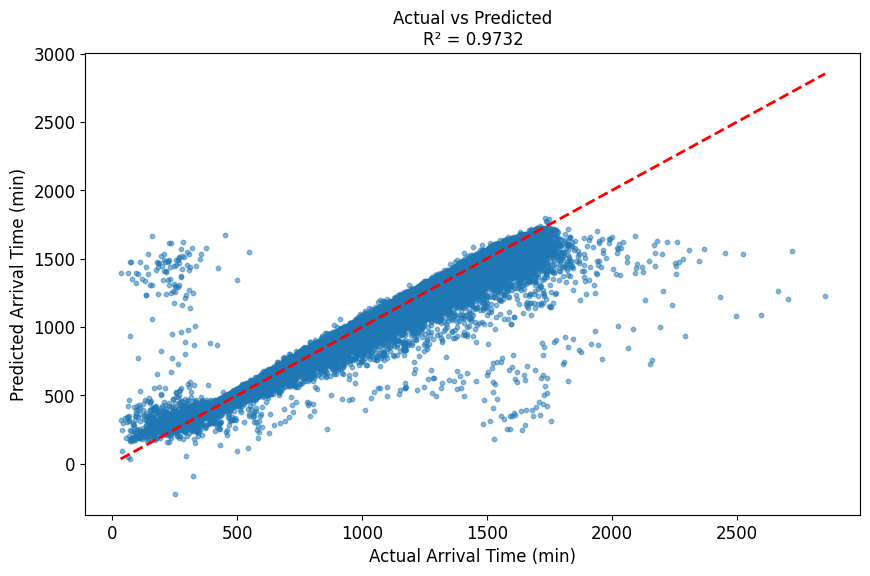

In [64]:
# visualization 2: Actual vs Predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_test, lgb_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Arrival Time (min)', fontsize=12)
plt.ylabel('Predicted Arrival Time (min)', fontsize=12)
plt.title(f'Actual vs Predicted\nR² = {lgb_r2:.4f}', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

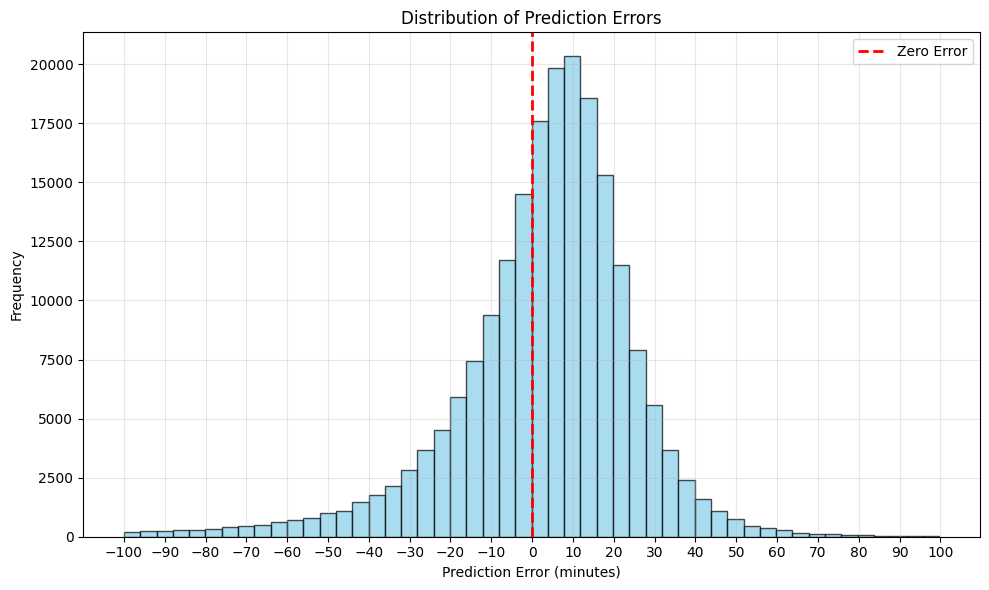

Errors in range (-100, 100): 200433 flights (98.0%)
Outliers: 4132 flights


In [65]:
# visualization 3: Prediction Errors

plt.figure(figsize=(10, 6))
errors = lgb_pred - y_test

# Ограничиваем диапазон
error_range = (-100, 100)
mask = (errors >= error_range[0]) & (errors <= error_range[1])
filtered_errors = errors[mask]

plt.hist(filtered_errors, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Error')

plt.xticks(np.arange(-100, 101, 10))
plt.xlabel('Prediction Error (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print(f"Errors in range {error_range}: {len(filtered_errors)} flights ({len(filtered_errors)/len(errors)*100:.1f}%)")
print(f"Outliers: {len(errors) - len(filtered_errors)} flights")

In [66]:
# performance summary

print(f'Mean Absolute Error: {lgb_mae:.2f} minutes')
print(f'Root Mean Square Error: {lgb_rmse:.2f} minutes')
print(f'R² Score: {lgb_r2:.4f}')
print(f'Explained Variance: {lgb_r2*100:.1f}%')

Mean Absolute Error: 20.90 minutes
Root Mean Square Error: 50.71 minutes
R² Score: 0.9732
Explained Variance: 97.3%
